In [248]:
import os
import numpy as np
import wandb
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import geopandas as gpd

from evtGAN import DCGAN, viz_utils, tf_utils
from importlib import reload
import wandb

def numpy_to_geopandas(data, xmin=80.0, xmax=95.0, ymin=10., ymax=25., crs=4326):
    h, w, c = data.shape
    
    x = np.linspace(xmin, xmax, w)
    y = np.linspace(ymin, ymax, h)
    x1 = [i  for j in y for i in x]
    y1 = [j for j in y for i in x][::-1]
    
    data = data.reshape(h * w, c)
    
    gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(x1, y1))
    gdf.columns = ['wind', 'wave', 'precip', 'geometry']
    gdf = gdf.set_crs(crs)
    return gdf

plt.rcParams["font.family"] = "monospace"

plot_kwargs = {'dpi': 500, 'bbox_inches': 'tight'}
hist_kwargs = {'density': True, 'color': 'blue', 'alpha': 0.6, 'edgecolor': 'blue'}

wd = "/Users/alison/Documents/DPhil/multivariate/cycloneGAN"

RUNNAME = 'zany-totem-121' # 'solar-sweep-1' # 'leafy-plant-114'
os.chdir(os.path.join(wd, 'saved-models', RUNNAME))
paddings = tf.constant([[0,0], [1,1], [1,1], [0,0]])

evt_type = "pot"
figdir = "/Users/alison/Documents/DPhil/multivariate/cycloneGAN/figures"

In [249]:
wandb.init(project='test', mode='disabled')
gan = DCGAN(wandb.config, nchannels=3)
gan.generator.load_weights(os.path.join(wd, 'saved-models', RUNNAME, f'generator_weights'))
gan.discriminator.load_weights(os.path.join(wd, 'saved-models', RUNNAME, f'discriminator_weights'))

In [250]:
reload(tf_utils)
fake = gan(1000)
train, test, params, images, thresholds = tf_utils.load_training_data("/Users/alison/Documents/DPhil/multivariate", evt_type=evt_type)

train = tf_utils.tf_unpad(train, paddings).numpy()
test = tf_utils.tf_unpad(test, paddings).numpy()
fake = tf_utils.tf_unpad(fake, paddings).numpy()

if evt_type == "pot":
    f_thresholds = tf_utils.interpolate_thresholds(thresholds, images, train)

n, h, w, c = train.shape

## Shapefiles

/Users/alison/mambaforge/envs/tf_geo/lib/python3.10/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


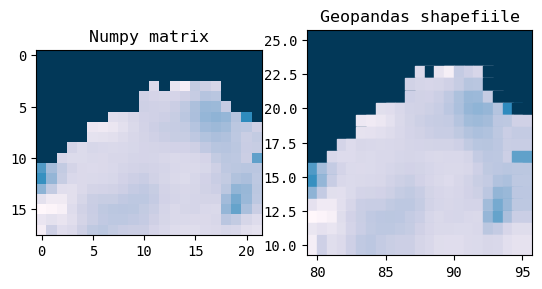

In [187]:
var_idx = 1
var = 'wave'


gdf = numpy_to_geopandas(train[0, ...])

fig, ax = plt.subplots(1, 2)
ax[0].imshow(train[0, ..., var_idx], cmap="PuBu_r")
gdf.plot(var, ax=ax[1], marker='s', s=200, cmap="PuBu_r");

ax[0].set_title('Numpy matrix')
ax[1].set_title("Geopandas shapefiile");

# Raster plots of parameters

In [457]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from evtGAN import tf_utils, viz_utils

plt.rcParams["font.family"] = "monospace"

ntrain = 2000
evt_type = "bm"
conditions = "all"
dim_dict = {'wind_data': 'total', 'wave_data': 'hmax', 'precip_data': 'tp'}
hist_kwargs = {'color': 'lightgrey', 'alpha': .6, 'edgecolor': 'k', 'density': True}

bounds = [80.0, 95.0, 10., 25.]

variable = 'wind_data'
evt_type = 'bm'
dim = dim_dict[variable]

datadir = f"/Users/alison/Documents/DPhil/multivariate/{variable}"
figdir = "/Users/alison/Documents/DPhil/multivariate/cycloneGAN/figures"
params = np.load(os.path.join(datadir, 'train', evt_type, 'params.npy'))
images = np.load(os.path.join(datadir, 'train', evt_type, 'images.npy'))

In [458]:
def numpy_to_tiff(array:np.array, filename:str, bounds, crs='EPSG:4326'):
    h, w, c = array.shape
    transform = rasterio.transform.from_bounds(*bounds, w, h)
    src = rasterio.open(filename, 'w', driver='GTiff', height=h, width=w, count=c,
                           dtype=array.dtype, crs=crs, transform=transform)
    for channel in range(c):
        src.write(array[..., channel], channel + 1)
    src.close()
    src = rasterio.open(filename)
    return src
    
    
src = numpy_to_tiff(params, os.path.join(datadir, 'train', evt_type, 'params.tif'), bounds)

In [459]:
import cartopy.crs as ccrs
from cartopy.feature import COASTLINE, LAND, OCEAN, BORDERS
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

def add_geoticks(ax, left=True, right=False, top=False, bottom=True):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='white', alpha=0., linestyle='--')
    gl.top_labels = top
    gl.bottom_labels = bottom
    gl.right_labels = right
    gl.left_labels = left
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

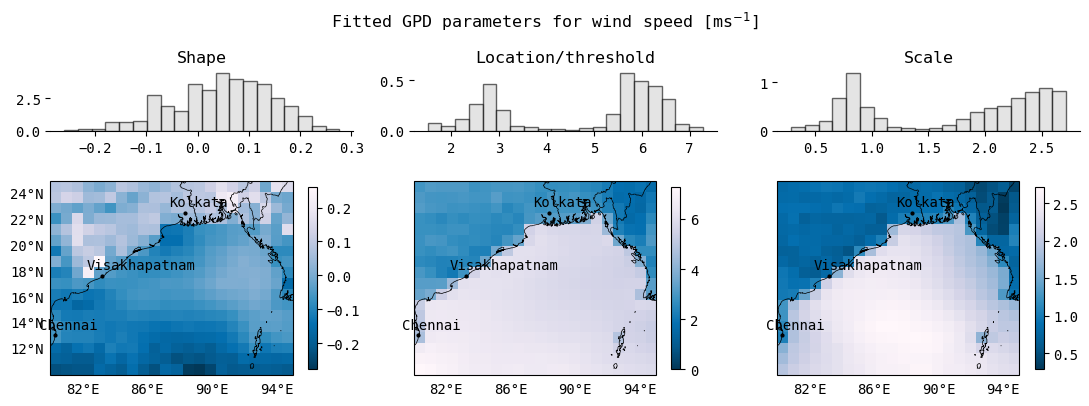

In [460]:
# plot spatially
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(11, 6), layout='tight',
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        gridspec_kw={'height_ratios': [1, 10]})

# plot the rasters
im0 = axs[1, 0].imshow(-src.read(1), origin='upper', transform=ccrs.PlateCarree(), cmap="PuBu_r", extent=bounds, zorder=2)
im1 = axs[1, 1].imshow(src.read(2), origin='upper', transform=ccrs.PlateCarree(), vmin=0, cmap="PuBu_r", extent=bounds, zorder=2)
im2 = axs[1, 2].imshow(src.read(3), origin='upper', transform=ccrs.PlateCarree(), cmap="PuBu_r", extent=bounds, zorder=2)

# for adding cities later
cities = {
    'Kolkata': (88.3639, 22.5726),
    'Chennai': (80.2707, 13.0827),
    'Visakhapatnam': (83.2185, 17.6868)
}

for ax in axs[1, :]:
    # add borders and coastlines
    ax.set_aspect(0.8)
    ax.add_feature(COASTLINE, linewidth=0.5, edgecolor='k', zorder=3)
    if variable == 'wave_data':
        ax.add_feature(LAND, facecolor='lightgrey', alpha=1, zorder=3);
    ax.add_feature(BORDERS, linewidth=0.5, edgecolor='k', zorder=3);
    
    # add cities
    for city, (lon, lat) in cities.items():
        ax.plot(lon, lat, marker='o', markersize=2, color='k', transform=ccrs.PlateCarree(), zorder=4)
        ax.text(lon - 1, lat + .5, city, transform=ccrs.PlateCarree(), zorder=4)

# add lonlat labels
add_geoticks(axs[1, 0])
add_geoticks(axs[1, 1], left=False)
add_geoticks(axs[1, 2], left=False)

# add colorbars
plt.colorbar(im0, ax=axs[1, 0], shrink=0.3)
plt.colorbar(im1, ax=axs[1, 1], shrink=0.3)
plt.colorbar(im2, ax=axs[1, 2], shrink=0.3)

# second row  
for i, ax in enumerate(axs[0, :]):
    ax.remove()
    axs[0, i] = fig.add_subplot(2, 3, 1 + i)
    axs[0, i].spines['top'].set_visible(False)
    axs[0, i].spines['right'].set_visible(False)
    axs[0, i].spines['left'].set_visible(False)

axs[0, 0].hist(params[..., 0].ravel(), bins=20, **hist_kwargs);
axs[0, 1].hist(params[..., 1][params[..., 1] > 0].ravel(), bins=20, **hist_kwargs);
axs[0, 2].hist(params[..., 2].ravel(), bins=20, **hist_kwargs);

#axs[0, 0].set_ylabel('Density')

axs[0, 0].set_title('Shape')
axs[0, 1].set_title('Location/threshold')
axs[0, 2].set_title('Scale');

fig.suptitle(f"Fitted GPD parameters for {viz_utils.variable_labels[variable]}");
fig.savefig(os.path.join(figdir, "general", f"params_{evt_type}_{variable}.png"), dpi=300, bbox_inches='tight')

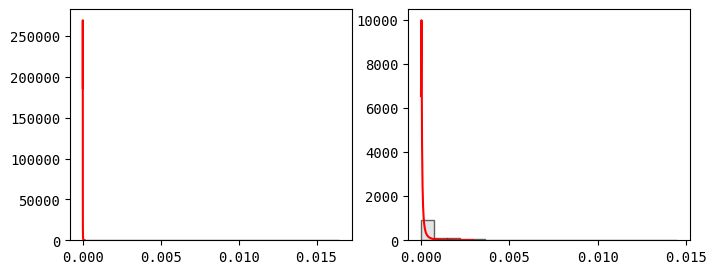

In [448]:
from scipy.stats import genextreme

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

i, j = 1, 1
ax[0].hist(images[:, i, j, 0], bins=20, **hist_kwargs);
bins = np.linspace(genextreme.ppf(0.01, *params[i, j]), genextreme.ppf(.99, *params[i, j]), 100)
ax[0].plot(bins, genextreme.pdf(bins, *params[i, j]), color='red')

i, j = 10, 10
ax[1].hist(images[:, i, j, 0], bins=20, **hist_kwargs);
bins = np.linspace(genextreme.ppf(0.01, *params[i, j]), genextreme.ppf(.99, *params[i, j]), 100)
ax[1].plot(bins, genextreme.pdf(bins, *params[i, j]), color='red')

## F-madograms
https://pro.arcgis.com/en/pro-app/latest/help/analysis/geostatistical-analyst/modeling-a-semivariogram.htm

$$\hat \gamma (h) = \frac{1}{|H|} \sum_{i, j \in H} \left( Y(x_i) - Y(x_j) \right)^2 \qquad H = \{i, j : d(x_i, x_j) = h\} $$


$$\hat \nu (h) = \frac{1}{|H|} \sum_{i, j \in H} |Z(x_i) - Z(x_j)| \qquad H = \{i, j : d(x_i, x_j) = h\} $$


In [234]:
import os
import numpy as np
import wandb
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


from evtGAN import DCGAN, viz_utils, tf_utils
from importlib import reload
import wandb


plt.rcParams["font.family"] = "monospace"
plot_kwargs = {'dpi': 500, 'bbox_inches': 'tight'}
hist_kwargs = {'density': True, 'color': 'lightgrey', 'alpha': 0.6, 'edgecolor': 'k'}

wd = "/Users/alison/Documents/DPhil/multivariate/cycloneGAN"

RUNNAME = 'solar-wind-126'#'icy-frog-125' # 'solar-sweep-1' # 'leafy-plant-114'
os.chdir(os.path.join(wd, 'saved-models', RUNNAME))
paddings = tf.constant([[0,0], [1,1], [1,1], [0,0]])

evt_type = "pot"
variable = "wave"
figdir = "/Users/alison/Documents/DPhil/multivariate/cycloneGAN/figures/results"

wandb.init(project='test', mode='disabled')
dcgan = DCGAN(wandb.config, nchannels=3)
dcgan.generator.load_weights(os.path.join(wd, 'saved-models', RUNNAME, f'generator_weights'))
dcgan.discriminator.load_weights(os.path.join(wd, 'saved-models', RUNNAME, f'discriminator_weights'))

dcgan.generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_15 (Dense)            (None, 25600)             2585600   
                                                                 
 reshape_23 (Reshape)        (None, 5, 5, 1024)        0         
                                                                 
 batch_normalization_37 (Bat  (None, 5, 5, 1024)       4096      
 chNormalization)                                                
                                                                 
 leaky_re_lu_45 (LeakyReLU)  (None, 5, 5, 1024)        0         
                                                                 
 dropout_45 (Dropout)        (None, 5, 5, 1024)        0         
                                                         

In [235]:
reload(tf_utils)
gan = dcgan(1000)
train, _, params, images, thresholds = tf_utils.load_training_data("/Users/alison/Documents/DPhil/multivariate", evt_type="pot", train_size=2000)
test, test_images, _ = tf_utils.load_test_data("/Users/alison/Documents/DPhil/multivariate")

train = tf_utils.tf_unpad(train, paddings).numpy()
test = tf_utils.tf_unpad(test, paddings).numpy()
gan = tf_utils.tf_unpad(gan, paddings).numpy()

f_thresholds = tf_utils.interpolate_thresholds(thresholds, images, train)

n, h, w, c = train.shape
train_gdf = numpy_to_geopandas(train[0, ...])
x = train_gdf.to_crs(3857).geometry.x.to_numpy()
y = train_gdf.to_crs(3857).geometry.y.to_numpy()
coords = np.stack([x, y], axis=-1)

/Users/alison/mambaforge/envs/tf_geo/lib/python3.10/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


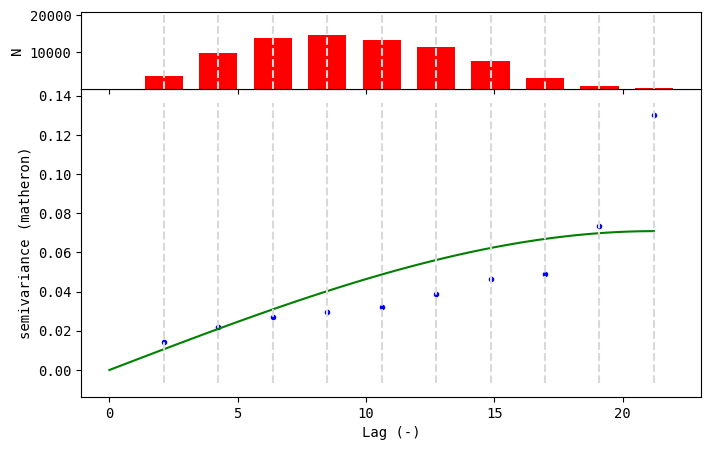

In [236]:
import numpy as np
from skgstat import Variogram

def semivariogram_skgstat(gdf, variable):
    x = gdf.geometry.x
    y = gdf.geometry.y
    z = gdf[variable]
    v = Variogram(coordinates=np.vstack((x, y)).T, values=z, normalize=False)
    return v

v_train = semivariogram(train_gdf, 'wind')
v.plot();

In [237]:
def semivariogram(gdf, attribute_column_name, nbins=10):
    # Extract the x and y coordinates from the geometry column
    x = gdf.geometry.x
    y = gdf.geometry.y
    
    # Extract the values from the attribute column
    z = gdf[attribute_column_name]
    
    # Calculate the semivariogram
    n = len(x)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            distances[i, j] = np.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2)
            distances[j, i] = distances[i, j]
    semivariance = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            semivariance[i, j] = (z[i] - z[j])**2
            semivariance[j, i] = semivariance[i, j]
            
    
    bins = np.linspace(0, np.max(distances), nbins)
    semivariogram = np.zeros(nbins)
    for i in range(nbins - 1):
        indices = np.where((distances >= bins[i]) & (distances < bins[i+1]))
        if len(indices[0]) > 0:
            semivariogram[i] = 0.5 * np.mean(semivariance[indices])
    
    return bins, semivariogram, distances


def fmadogram(gdf, attribute_column_name, nbins=10):
    # Extract the x and y coordinates from the geometry column
    x = gdf.geometry.x
    y = gdf.geometry.y
    
    # Extract the values from the attribute column
    z = gdf[attribute_column_name]
    z = 1. / (1 - np.log(z))  # unit frechet margins
    
    # Calculate the semivariogram
    n = len(x)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            distances[i, j] = np.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2)
            distances[j, i] = distances[i, j]
    semivariance = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            semivariance[i, j] = np.abs(z[i] - z[j])
            semivariance[j, i] = semivariance[i, j]
            
    
    bins = np.linspace(0, np.max(distances), nbins)
    semivariogram = np.zeros(nbins)
    for i in range(nbins - 1):
        indices = np.where((distances >= bins[i]) & (distances < bins[i+1]))
        if len(indices[0]) > 0:
            semivariogram[i] = 0.5 * np.mean(semivariance[indices])
    
    # Return the semivariogram
    return bins, semivariogram, distances

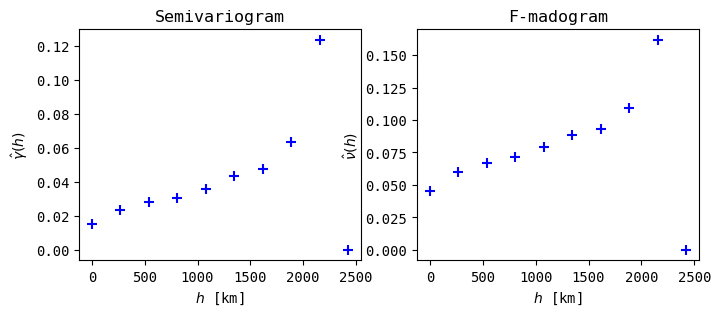

In [240]:
# Calculate the semivariogram
variable = "wind"

nbins = 10
bins, gamma, distances = semivariogram(train_gdf.to_crs(3857), variable, nbins)
bins, nu, distances = fmadogram(train_gdf.to_crs(3857), variable, nbins)
bins /= 1000

# Plot the semivariogram
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
# viz_utils.scatter_density2(bins, gamma, ax=ax, cmap='PuBu')
ax[0].scatter(bins, gamma, marker='+', color='blue', s=50)
ax[0].set_ylabel(r"$\hat \gamma(h)$")
ax[0].set_xlabel(r"$h$ [km]");
ax[0].set_title("Semivariogram");

ax[1].scatter(bins, nu, marker='+', color='blue', s=50)
ax[1].set_ylabel(r"$\hat \nu(h)$")
ax[1].set_xlabel(r"$h$ [km]");
ax[1].set_title("F-madogram");